In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [12]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3.db'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [13]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [14]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values, added .astype(str)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

X = MultiColumnLabelEncoder(columns = None).fit_transform(df.astype(str))

## Isolation Forest, train and test parts

Three fundamental approaches to detect anomalies are: isolation, density, and distance. Here we look at isolation. The dataset is split into the train and test parts to test the predictions of iForest and evaluate its performance on new data.
Also, according to https://github.com/scikit-learn/scikit-learn/issues/3112, label encoding doesn't really belong in a Pipeline therefore it is removed and Pipeline for now has only one step.

In [5]:
IFT = IsolationForest(n_estimators=100, max_samples=256, max_features=35, contamination=.15)
pipeline = Pipeline([('IFT', IFT)])

In [6]:
X_train, X_test = train_test_split(X, test_size = 0.12, random_state = 100)

In [7]:
model = pipeline.fit(X_train)
predicted = pipeline.predict(X_test)

In [8]:
X_test['ift'] = predicted

C:\Users\SKK\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
# anomaly scores, decision function splits them at 0
anomaly_score = pipeline.decision_function(X_test)

C:\Users\SKK\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


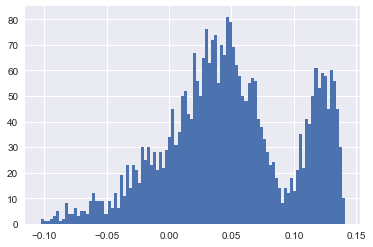

In [10]:
X_test['ift_anom_score'] = anomaly_score
X_test.ift_anom_score.hist(bins=100)
plt.show()

In [11]:
# find a substring 'bot' in the userAgentHttp column (assuming that only good bots openly identify themselves as bots)
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
# calculate a frequency column for api keys per each hour in the dataset
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
# create a new column for frequent ids if the same user has accessed the site >10 times per hour (mark as 1, otherwise 0)
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>15, 1, 0)

In [12]:
X['frequent/hour'].value_counts()

0    19541
1     6569
Name: frequent/hour, dtype: int64

In [13]:
# not sure how to get the X columns into X_test with iloc
X_test["GoodBot"] = X["GoodBot"]
X_test['frequent/hour'] = X['frequent/hour']

C:\Users\SKK\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\SKK\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
my = pd.crosstab(X_test['ift'], X_test['GoodBot'], margins=True)
my

GoodBot,0,1,All
ift,,,
-1,429,20,449
1,2678,7,2685
All,3107,27,3134


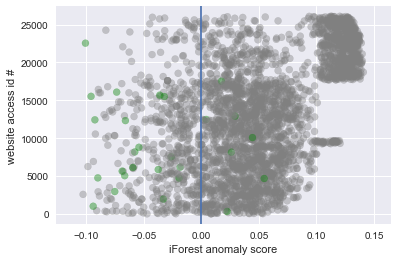

In [15]:
arr1 = X_test['ift_anom_score']
arr2 = X_test.index
labl = X_test['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color=color, alpha=0.4)
plt.axvline(x=0)
plt.xlabel('iForest anomaly score')
plt.ylabel('website access id #')
plt.show()

In [16]:
# Pickle the pipeline model with iForest (train/test)
fn = pickle.dumps(model)
picpipe_iFst = pickle.loads(fn)
# picpipe_iFst.predict(X_test)

## Isolation Forest, the whole dataset

In [17]:
# dropping newly created columns, returning to the original dataset
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [18]:
ift_f = IFT.fit(X)

In [19]:
ift_y = IFT.predict(X)

In [20]:
X['ift_y'] = ift_y

In [21]:
anomaly_score = pipeline.decision_function(X)

In [22]:
X['anomaly_score'] = anomaly_score

In [23]:
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>15, 1, 0)

In [24]:
my = pd.crosstab(X['ift_y'], X['GoodBot'], margins=True)
my

GoodBot,0,1,All
ift_y,,,
-1,3768,149,3917
1,22159,34,22193
All,25927,183,26110


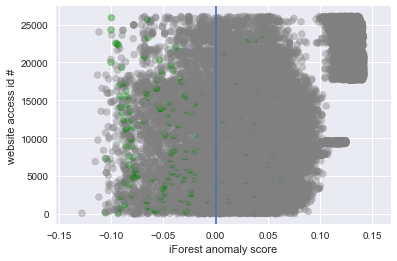

In [25]:
arr1 = X['anomaly_score']
arr2 = X.index
labl = X['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color=color, alpha=0.4)
plt.axvline(x=0)
plt.xlabel('iForest anomaly score')
plt.ylabel('website access id #')
plt.show()

## One-class SVM

As per scikit learn documentation, the One-class SVM is not an outlier-detection method but a novelty-detection method, its training set should not have outliers as it may fit them. (Otherwise known as a semi-supervised method which uses only normal examples during training  to build a model of normality). However, One-class SVM gives useful results in outlier detection in high-dimension dataset with no known distribution of the data.

In [23]:
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [15]:
X_train, X_test = train_test_split(X, test_size = 0.12, random_state = 100)

In [16]:
SVM = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.00004)
%timeit SVM.fit(X_train)
pred_SVM = SVM.predict(X_test)

1 loop, best of 3: 3min 17s per loop


In [17]:
# if there are many more outliers than normal data, need to tune the parameters
itemfreq(pred_SVM)

array([[ -1.00000000e+00,   3.02200000e+03],
       [  1.00000000e+00,   1.12000000e+02]])

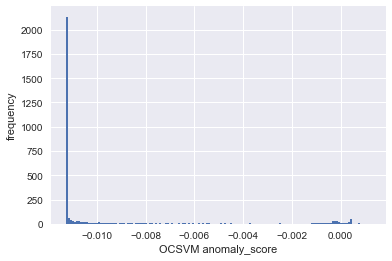

In [18]:
anomaly_score = SVM.decision_function(X_test)
plt.hist(anomaly_score, bins=150)
plt.xlabel('OCSVM anomaly_score')
plt.ylabel('frequency')
plt.show()

In [19]:
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>15, 1, 0)

In [20]:
X_test["GoodBot"] = X["GoodBot"]
X_test['api/hour'] = X['api/hour']
X_test['frequent/hour'] = X['frequent/hour']
X_test['SVM'] = pred_SVM

C:\Users\SK-K\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\SK-K\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\SK-K\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [21]:
# a quick check if OCSVM detected our good bots
tabs=pd.crosstab(X_test.SVM, X_test.GoodBot, margins=True)
tabs

GoodBot,0,1,All
SVM,,,
-1.0,2996,26,3022
1.0,111,1,112
All,3107,27,3134


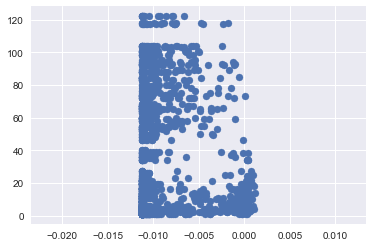

In [22]:
plt.scatter(anomaly_score,X_test['api/hour'])
plt.show()